# Daily exchange rates

## Pre-processing

In [1]:
import pandas as pd

In [2]:
dfs = []
currencies = ['EUR', 'GBP', 'JPY', 'USD']
for currency in currencies:
    # Read single currency CSV
    df = pd.read_csv(f'data/{currency}.csv', skiprows=4, sep=';')
    
    # Remove empty last column
    df = df.iloc[:, :-1]
    
    # Format date string to datetime
    df.Date = pd.to_datetime(df.Date, format='%d-%m-%Y')
    
    # Set date as index, for concatenation
    df.set_index('Date', inplace=True)
    
    dfs.append(df)
    
# Concat currencies and rename columns
df = pd.concat(dfs, axis=1)
df.index.rename('date', inplace=True)
columns = ['eur', 'gbp', 'jpy', 'usd']
df.columns = columns

# Convert GBP string to numeric
df.gbp = pd.to_numeric(df.gbp.replace(',', '', regex=True))

# Convert from price of 100DKK in CURR to price of 1DKK in CURR
df[columns] /= 100

# Keep only the last 5 years
df = df.last('5Y')

## Exhange Rates Last 5 Years

In [3]:
for curr in df.columns:
    capital_curr = curr.upper()
    value, date = df[curr].min(), df[curr].idxmin().date()
    print(f'{capital_curr}/DKK')
    print(f'Highest depreciation: {value:.2f}{capital_curr} per 1DKK on {date}')
    print()

EUR/DKK
Highest depreciation: 7.44EUR per 1DKK on 2021-09-20

GBP/DKK
Highest depreciation: 8.04GBP per 1DKK on 2020-03-23

JPY/DKK
Highest depreciation: 0.05JPY per 1DKK on 2022-06-08

USD/DKK
Highest depreciation: 5.96USD per 1DKK on 2018-02-02



In [4]:
import matplotlib.pyplot as plt
from datetime import date

# Set theme and font settings
plt.style.use('seaborn-paper')
plt.rcParams["figure.dpi"] = 60
font_scalar = 2
SMALL_SIZE = 8 * font_scalar
MEDIUM_SIZE = 10 * font_scalar
BIGGER_SIZE = 12 * font_scalar

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
def plot_currencies(colors=['#e1be6a', '#40b0a6', '#6A8DE1'], opacity=1.):
    c_eur, c_usd, c_gbp = colors
    
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    ax = fig.add_subplot(111)

    # Plot lines
    ax.plot(df.index, df.usd, c=c_usd, alpha=opacity)
    ax.plot(df.index, df.gbp, c=c_gbp, alpha=opacity)
    ax.plot(df.index, df.eur, c=c_eur, alpha=opacity)

    # Plot labels
    c_eur = '#e1be6a'
    c_usd = '#40b0a6'
    c_gbp = '#6A8DE1'
    latest_usd_value = df.usd.iloc[-1]
    latest_gbp_value = df.gbp.iloc[-1]
    latest_eur_value = df.eur.iloc[-1]
    label_x = date.fromisoformat('2022-09-30')
    ax.text(label_x, latest_usd_value * 1.01, 'USD', color=c_usd, va='center')
    ax.text(label_x, latest_gbp_value, 'GBP', color=c_gbp, va='center')
    ax.text(label_x, latest_eur_value * 0.99, 'EUR', color=c_eur, va='center')
    ax.set_ylabel('Value per DKK')

    for ax in fig.get_axes():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return ax

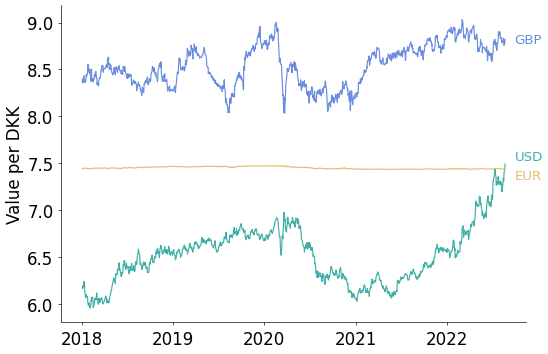

In [5]:
plot_currencies()

## Daily Percentage Change

In [6]:
df_change = df.pct_change(1)

pos_change = pd.DataFrame(zip(df_change.idxmax(), df_change.max()))
pos_change.columns = ['date', 'max']
pos_change.set_index(df_change.idxmax().index, inplace=True)
pos_change['value'] = pos_change.apply(lambda row: df.loc[row.date, row.name], axis=1)

neg_change = pd.DataFrame(zip(df_change.idxmin(), df_change.min()))
neg_change.columns = ['date', 'min']
neg_change.set_index(df_change.idxmin().index, inplace=True)
neg_change['value'] = neg_change.apply(lambda row: df.loc[row.date, row.name], axis=1)

In [7]:
pos_change

,date,max,value
eur,2020-03-30,0.000818,7.466700
gbp,2019-10-11,0.030179,8.534000
jpy,2022-05-12,0.024321,0.055594
usd,2022-02-24,0.016439,6.665300


In [8]:
neg_change

,date,min,value
eur,2020-03-27,-0.000710,7.460600
gbp,2020-03-23,-0.020694,8.035500
jpy,2022-06-17,-0.021056,0.052676
usd,2022-02-04,-0.014944,6.492700


Text(0.5, 1.0, 'Extreme Daily Percentage Change')

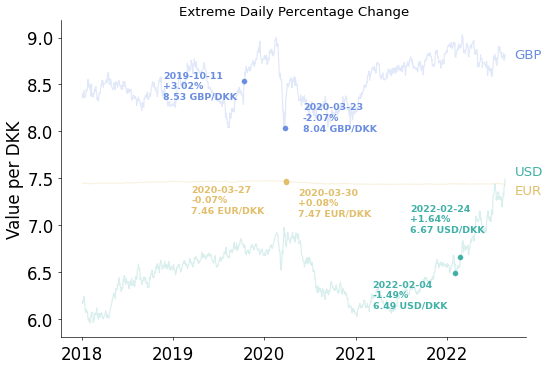

In [14]:
ax = plot_currencies(opacity=0.2)

c_usd = '#40b0a6'
c_eur = '#e1be6a'
c_gbp = '#6A8DE1'

# GBP
# Positive change
x = pos_change.loc['gbp', 'date']
y = pos_change.loc['gbp', 'value']
pct = 100*pos_change.loc['gbp', 'max']

ax.scatter(x, y, c=c_gbp, s=40, zorder=10)
label = f"{x.date()}\n+{pct:.2f}%\n{y:.2f} GBP/DKK"
ax.text(0.22, 0.84, label, color=c_gbp, va='top', ha='left', fontsize=SMALL_SIZE*0.7, transform=ax.transAxes, fontweight='bold')

# Negative change
x = neg_change.loc['gbp', 'date']
y = neg_change.loc['gbp', 'value']
pct = 100*neg_change.loc['gbp', 'min']

ax.scatter(x, y, c=c_gbp, s=40, zorder=10)
label = f"{x.date()}\n{pct:.2f}%\n{y:.2f} GBP/DKK"
ax.text(0.52, 0.74, label, color=c_gbp, va='top', ha='left', fontsize=SMALL_SIZE*0.7, transform=ax.transAxes, fontweight='bold')

# USD
# Positive change
x = pos_change.loc['usd', 'date']
y = pos_change.loc['usd', 'value']
pct = 100*pos_change.loc['usd', 'max']

ax.scatter(x, y, c=c_usd, s=40, zorder=10)
label = f"{x.date()}\n+{pct:.2f}%\n{y:.2f} USD/DKK"
ax.text(0.75, 0.42, label, color=c_usd, va='top', ha='left', fontsize=SMALL_SIZE*0.7, transform=ax.transAxes, fontweight='bold')

# Negative change
x = neg_change.loc['usd', 'date']
y = neg_change.loc['usd', 'value']
pct = 100*neg_change.loc['usd', 'min']

ax.scatter(x, y, c=c_usd, s=40, zorder=10)
label = f"{x.date()}\n{pct:.2f}%\n{y:.2f} USD/DKK"
ax.text(0.67, 0.18, label, color=c_usd, va='top', ha='left', fontsize=SMALL_SIZE*0.7, transform=ax.transAxes, fontweight='bold')

# EUR
# Positive change
x = pos_change.loc['eur', 'date']
y = pos_change.loc['eur', 'value']
pct = 100*pos_change.loc['eur', 'max']

ax.scatter(x, y, c=c_eur, s=40, zorder=10)
label = f"{x.date()}\n+{pct:.2f}%\n{y:.2f} EUR/DKK"
ax.text(0.51, 0.47, label, color=c_eur, va='top', ha='left', fontsize=SMALL_SIZE*0.7, transform=ax.transAxes, fontweight='bold')

# Negative change
x = neg_change.loc['eur', 'date']
y = neg_change.loc['eur', 'value']
pct = 100*neg_change.loc['eur', 'min']

ax.scatter(x, y, c=c_eur, s=40, zorder=10)
label = f"{x.date()}\n{pct:.2f}%\n{y:.2f} EUR/DKK"
ax.text(0.28, 0.48, label, color=c_eur, va='top', ha='left', fontsize=SMALL_SIZE*0.7, transform=ax.transAxes, fontweight='bold')

ax.set_title('Extreme Daily Percentage Change')